# Load required packages

In [1]:
import pandas as pd
import numpy as np

import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import math
from collections import Counter
import re
import json
from bs4 import BeautifulSoup
import datetime
from pprint import pprint
import requests
import os

In [2]:
from keras.preprocessing import image as image_utils
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import VGG16

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout

Using TensorFlow backend.


# Load images for testing

In [67]:
# collect image's path
test_imgs = glob.glob('test_images/avenger/test*.jpg')

In [68]:
len(test_imgs)

4

In [69]:
# use each path to read in the image and assign to a list
test_imgs_list=[]
for i in test_imgs:
    temp = cv2.imread(i)
    test_imgs_list.append(temp)

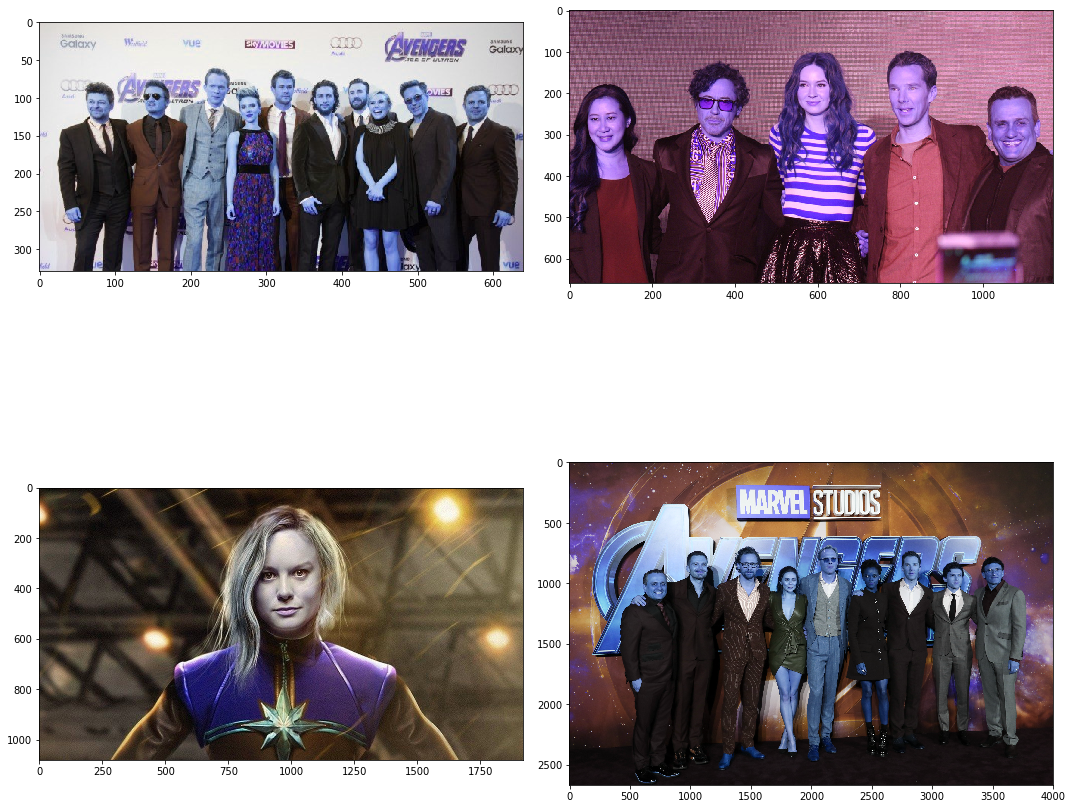

In [155]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(test_imgs_list[0])
plt.subplot(2,2,2)
plt.imshow(test_imgs_list[1])
plt.subplot(2,2,3)
plt.imshow(test_imgs_list[2])
plt.subplot(2,2,4)
plt.imshow(test_imgs_list[3])

plt.tight_layout()
plt.savefig('test_images/avenger/all_tests.jpg', format='jpg', dpi=100)

# Load functions of sliding windows

In [14]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [15]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Demonstration

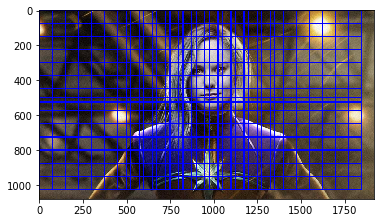

In [159]:
demo_img = test_imgs_list[2].copy()
demo_windows = slide_window(demo_img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(500, 500), xy_overlap=(0.85, 0.85))
demo_img_windows = draw_boxes(demo_img, demo_windows)

plt.imshow(demo_img_windows)
plt.savefig('test_images/avenger/demo.jpg', format='jpg', dpi=100)

# Load functions of heatmap

In [23]:
# Apply classifier onto each window from a window grid

def box_piles(data, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(20, 20), xy_overlap=(0.5, 0.5)):
    # create window grid for the image
    windows = slide_window(data, x_start_stop, y_start_stop, xy_window, xy_overlap)
    # use each window to predict whether there is a face
    on_windows = []
    for window in windows:
        #3) Extract the test window from original image and Transform each window into (32,32)
        test_img = cv2.resize(data[window[0][1]:window[1][1], window[0][0]:window[1][0]], (32, 32))      
        #4) Add a extra layer to each resized window and transform pixels to 0~1 for classifier 
        test_img = test_img.reshape(1, 32, 32, 3)
        test_img_transform = test_img.astype('float32')
        test_img_transform /= 255   
        #5) Predict each window by classifier
        prediction = model.predict(test_img_transform)
        #6) If positive (prediction == 1) then save the window
        if prediction[0][1] >= 0.90:
            on_windows.append(window)
    return on_windows

In [18]:
# Add += 1 for all pixels inside each window
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

# Zero out pixels below the threshold    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [20]:
# use information above to create a heat map and group multiple windows into facial counts by label function
from scipy.ndimage.measurements import label

def draw_heatmap(img, all_boxes, threshold):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, all_boxes)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    return heatmap, labels

# Load functions of heatmap with shrinked windows

In [74]:
def add_small_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # calculate the length of each box
        box_len_x = box[1][0] - box[0][0]
        box_len_y = box[1][1] - box[0][1]
        # calculate the length to shrink; here is to downsize to 1/2
        shrink_len_x = int(box_len_x / 4)
        shrink_len_y = int(box_len_y / 4)
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[(box[0][1]+shrink_len_y):(box[1][1]-shrink_len_y), (box[0][0]+shrink_len_x):(box[1][0]-shrink_len_x)] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [21]:
from scipy.ndimage.measurements import label
from scipy.ndimage import generate_binary_structure
s = generate_binary_structure(2,2)

def draw_small_heatmap(img, all_boxes, threshold):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_small_heat(heat, all_boxes)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap, structure=s)
    return heatmap, labels

# Load functions of labeled boxes 

In [22]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Load model8

In [24]:
from pathlib import Path
f = Path('model6_structure.json')
model_structure = f.read_text()
from keras.models import model_from_json
model = model_from_json(model_structure)

model.load_weights("model8_weights.h5")

# The image with 1 face

In [103]:
# serach face by windows in 3 different scales
# roughly estimate the facial size from the original image ex: 500 x 500 here

test_heat = test_imgs_list[2].copy()
boxes1 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None,None], xy_window=(500,500), xy_overlap=(0.85, 0.85))
boxes2 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None,None], xy_window=(550,550), xy_overlap=(0.85, 0.85))
boxes3 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None,None], xy_window=(600,600), xy_overlap=(0.85, 0.85))
# combine all windows
all_boxes = np.concatenate((np.array(boxes1), np.array(boxes2), np.array(boxes3)), axis=0)
len(all_boxes)

6

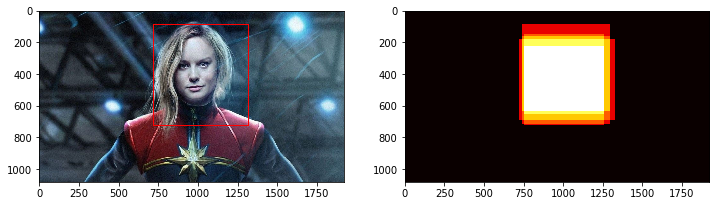

In [104]:
heatmap, labels = draw_heatmap(test_heat, all_boxes, 1)
final_box = draw_labeled_bboxes(np.copy(test_heat), labels)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(final_box[:,:,::-1])

plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='hot')
plt.savefig('1face.jpg', format='jpg', dpi=100)

# The image with 5 faces

In [160]:
# serach face by windows in 3 different scales
# roughly estimate the facial size from the original image ex: 150 x 150 here

test_heat = test_imgs_list[1].copy()
boxes1 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None,None], xy_window=(150,150), xy_overlap=(0.85, 0.85))
boxes2 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None,None], xy_window=(200,200), xy_overlap=(0.85, 0.85))
boxes3 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None,None], xy_window=(250,250), xy_overlap=(0.85, 0.85))
# combine all windows
all_boxes = np.concatenate((np.array(boxes1), np.array(boxes2), np.array(boxes3)), axis=0)
len(all_boxes)

135

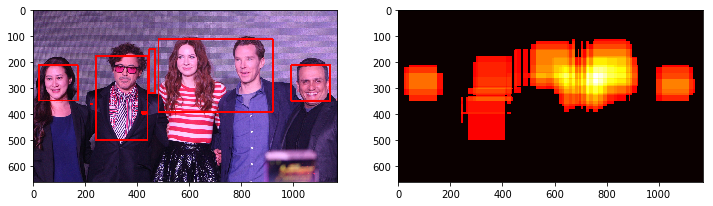

In [161]:
heatmap, labels = draw_heatmap(test_heat, all_boxes, 12)
final_box = draw_labeled_bboxes(np.copy(test_heat), labels)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(final_box[:,:,::-1])

plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='hot')
plt.savefig('test_images/avenger/5face.jpg', format='jpg', dpi=100)

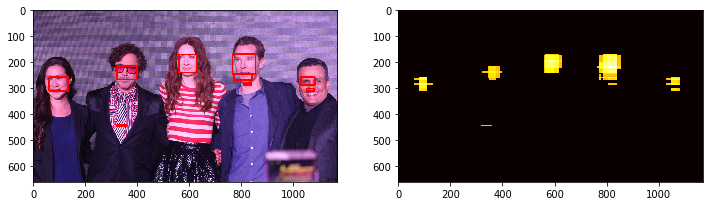

In [100]:
heatmap, labels = draw_small_heatmap(test_heat, all_boxes, 12)
final_box = draw_labeled_bboxes(np.copy(test_heat), labels)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(final_box[:,:,::-1])

plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='hot')
plt.savefig('test_images/avenger/5face_1.jpg', format='jpg', dpi=100)

# The image with 9 faces

In [107]:
# serach face by windows in 3 different scales
# roughly estimate the facial size from the original image ex: 200 x 200 here

test_heat = test_imgs_list[3].copy()
boxes1 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None,None], xy_window=(250,250), xy_overlap=(0.85, 0.85))
boxes2 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None,None], xy_window=(300,300), xy_overlap=(0.85, 0.85))
boxes3 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None,None], xy_window=(350,350), xy_overlap=(0.85, 0.85))
# combine all windows
all_boxes = np.concatenate((np.array(boxes1), np.array(boxes2), np.array(boxes3)), axis=0)
len(all_boxes)

362

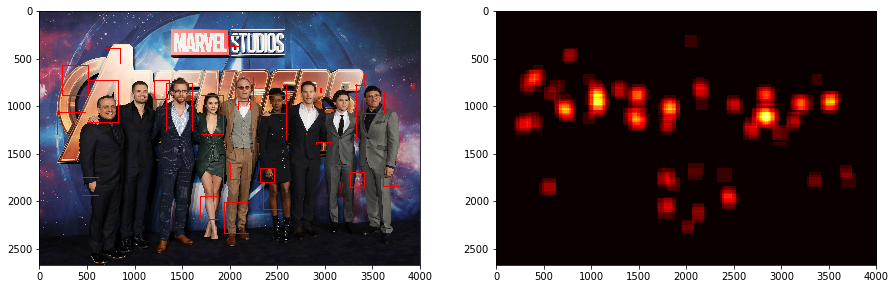

In [110]:
heatmap, labels = draw_small_heatmap(test_heat, all_boxes, 1)
final_box = draw_labeled_bboxes(np.copy(test_heat), labels)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(final_box[:,:,::-1])

plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='hot')
plt.savefig('test_images/avenger/9face.jpg', format='jpg', dpi=100)

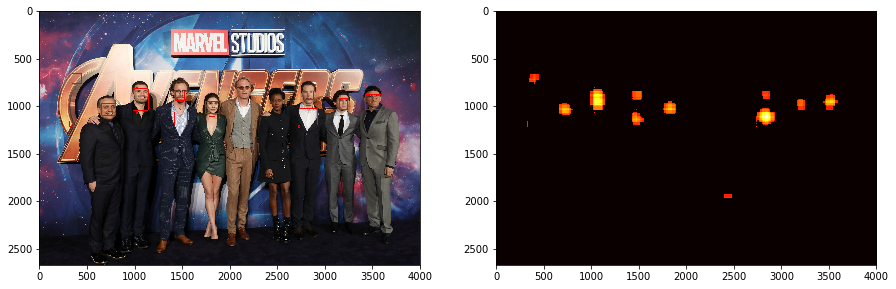

In [111]:
heatmap, labels = draw_small_heatmap(test_heat, all_boxes, 10)
final_box = draw_labeled_bboxes(np.copy(test_heat), labels)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(final_box[:,:,::-1])

plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='hot')
plt.savefig('test_images/avenger/9face_1.jpg', format='jpg', dpi=100)

# The image with 10 faces

In [162]:
# serach face by windows in 3 different scales
# roughly estimate the facial size from the original image ex: 50 x 50 here

test_heat = test_imgs_list[0].copy()
boxes1 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None,None], xy_window=(50,50), xy_overlap=(0.85, 0.85))
boxes2 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None,None], xy_window=(60,60), xy_overlap=(0.85, 0.85))
boxes3 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None,None], xy_window=(70,70), xy_overlap=(0.85, 0.85))
# combine all windows
all_boxes = np.concatenate((np.array(boxes1), np.array(boxes2), np.array(boxes3)), axis=0)
len(all_boxes)

389

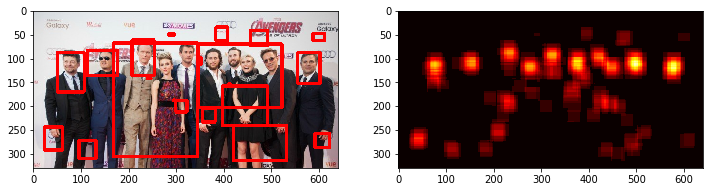

In [163]:
heatmap, labels = draw_small_heatmap(test_heat, all_boxes, 1)
final_box = draw_labeled_bboxes(np.copy(test_heat), labels)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(final_box[:,:,::-1])

plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='hot')
plt.savefig('test_images/avenger/10face.jpg', format='jpg', dpi=100)

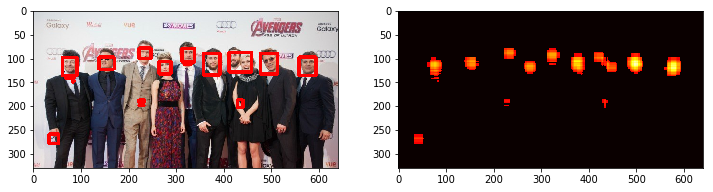

In [164]:
heatmap, labels = draw_small_heatmap(test_heat, all_boxes, 10)
final_box = draw_labeled_bboxes(np.copy(test_heat), labels)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(final_box[:,:,::-1])

plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='hot')

plt.savefig('test_images/avenger/10face_2.jpg', format='jpg', dpi=100)

# Load crowd images

In [118]:
crowd = glob.glob('test_images/crowd/test*.jpg')

In [119]:
# use each path to read in the image and assign to a list
crowd_list=[]
for i in crowd:
    temp = cv2.imread(i)
    crowd_list.append(temp)

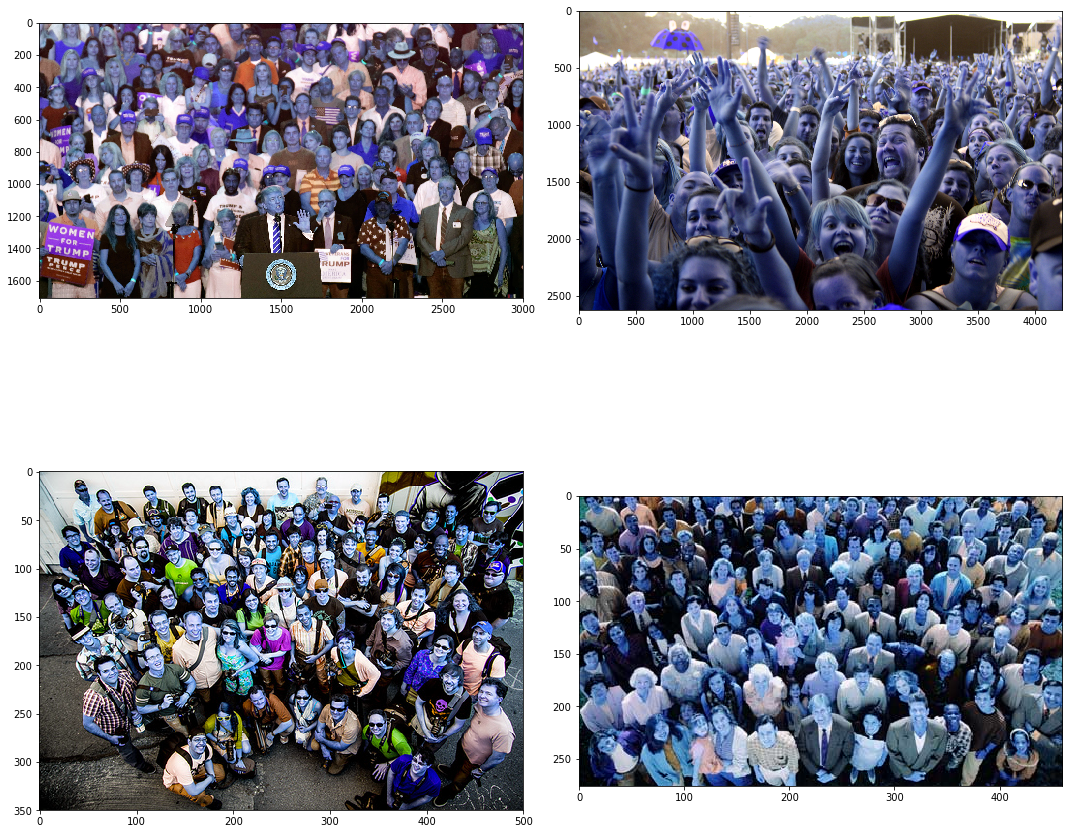

In [156]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(crowd_list[0])
plt.subplot(2,2,2)
plt.imshow(crowd_list[1])
plt.subplot(2,2,3)
plt.imshow(crowd_list[2])
plt.subplot(2,2,4)
plt.imshow(crowd_list[3])

plt.tight_layout()
plt.savefig('test_images/crowd/all_crowd.jpg', format='jpg', dpi=100)

# Crowd image1

In [165]:
# serach face by window in 3 different scales
test_heat = crowd_list[0].copy()
boxes1 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(125,125), xy_overlap=(0.85, 0.85))
boxes2 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(190,190), xy_overlap=(0.85, 0.85))
boxes3 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(250,250), xy_overlap=(0.85, 0.85))
# combine all windows
all_boxes = np.concatenate((np.array(boxes1), np.array(boxes2), np.array(boxes3)), axis=0)
len(all_boxes)

1532

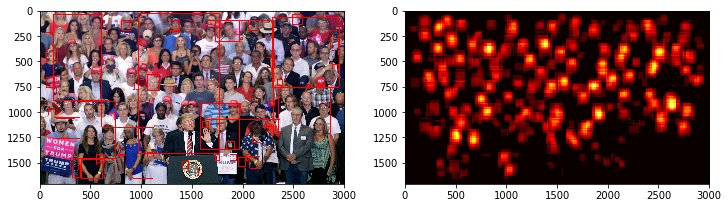

In [166]:
heatmap, labels = draw_small_heatmap(test_heat, all_boxes, 1)
final_box = draw_labeled_bboxes(np.copy(test_heat), labels)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(final_box[:,:,::-1])

plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='hot')

plt.savefig('test_images/crowd/test4_count.jpg', format='jpg', dpi=100)

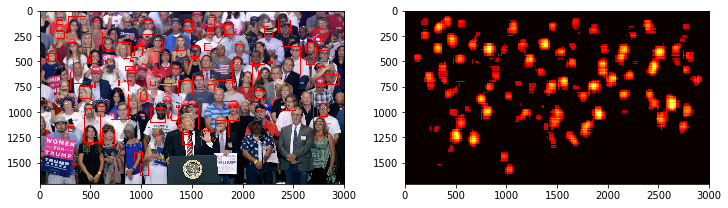

In [168]:
heatmap, labels = draw_small_heatmap(test_heat, all_boxes, 5)
final_box = draw_labeled_bboxes(np.copy(test_heat), labels)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(final_box[:,:,::-1])

plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='hot')

plt.savefig('test_images/crowd/test4_count_1.jpg', format='jpg', dpi=100)

In [169]:
labels[1]

167

# Crowd image 2

In [133]:
# serach face by window in 3 different scales
test_heat = crowd_list[1].copy()
boxes1 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(450,450), xy_overlap=(0.85, 0.85))
boxes2 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(500,500), xy_overlap=(0.85, 0.85))
boxes3 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(550,550), xy_overlap=(0.85, 0.85))
# combine all windows
all_boxes = np.concatenate((np.array(boxes1), np.array(boxes2), np.array(boxes3)), axis=0)
len(all_boxes)

93

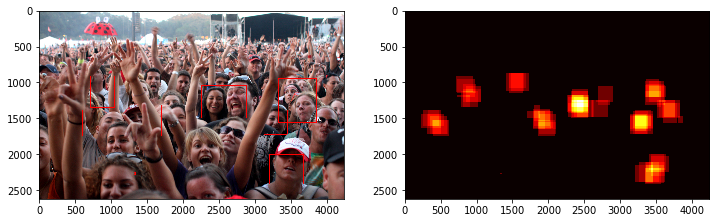

In [134]:
heatmap, labels = draw_small_heatmap(test_heat, all_boxes, 1)
final_box = draw_labeled_bboxes(np.copy(test_heat), labels)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(final_box[:,:,::-1])

plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='hot')

plt.savefig('test_images/crowd/test1_count.jpg', format='jpg', dpi=100)

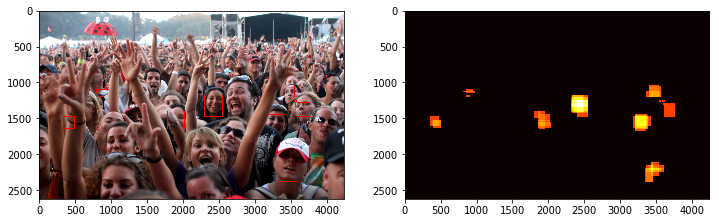

In [135]:
heatmap, labels = draw_small_heatmap(test_heat, all_boxes, 5)
final_box = draw_labeled_bboxes(np.copy(test_heat), labels)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(final_box[:,:,::-1])

plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='hot')

plt.savefig('test_images/crowd/test1_count_1.jpg', format='jpg', dpi=100)

# Corwd image 3

In [136]:
# serach face by window in 3 different scales
test_heat = crowd_list[2].copy()
boxes1 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(30,30), xy_overlap=(0.85, 0.85))
boxes2 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(45,45), xy_overlap=(0.85, 0.85))
boxes3 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(60,60), xy_overlap=(0.85, 0.85))
# combine all windows
all_boxes = np.concatenate((np.array(boxes1), np.array(boxes2), np.array(boxes3)), axis=0)
len(all_boxes)

1167

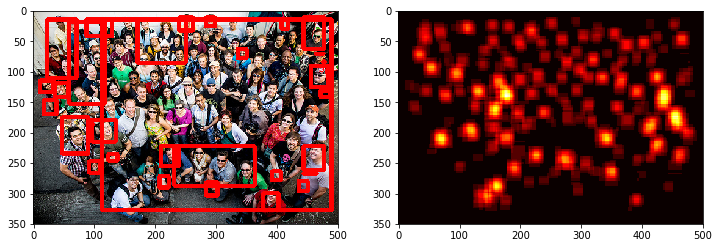

In [137]:
heatmap, labels = draw_small_heatmap(test_heat, all_boxes, 1)
final_box = draw_labeled_bboxes(np.copy(test_heat), labels)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(final_box[:,:,::-1])

plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='hot')

plt.savefig('test_images/crowd/test3_count.jpg', format='jpg', dpi=100)

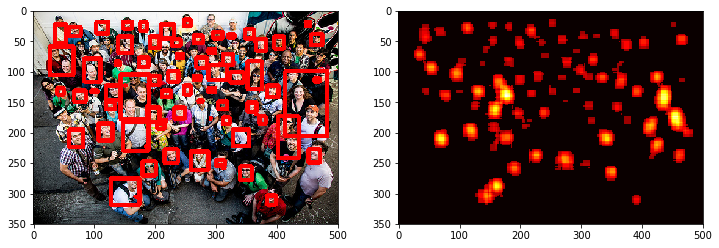

In [138]:
heatmap, labels = draw_small_heatmap(test_heat, all_boxes, 5)
final_box = draw_labeled_bboxes(np.copy(test_heat), labels)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(final_box[:,:,::-1])

plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='hot')

plt.savefig('test_images/crowd/test3_count_1.jpg', format='jpg', dpi=100)

In [146]:
labels[1]

77

# Crowd image 4

In [170]:
# serach face by window in 3 different scales
test_heat = crowd_list[3].copy()
boxes1 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(20,20), xy_overlap=(0.85, 0.85))
boxes2 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(25,25), xy_overlap=(0.85, 0.85))
boxes3 = box_piles(test_heat, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(30,30), xy_overlap=(0.85, 0.85))
# combine all windows
all_boxes = np.concatenate((np.array(boxes1), np.array(boxes2), np.array(boxes3)), axis=0)
len(all_boxes)

2278

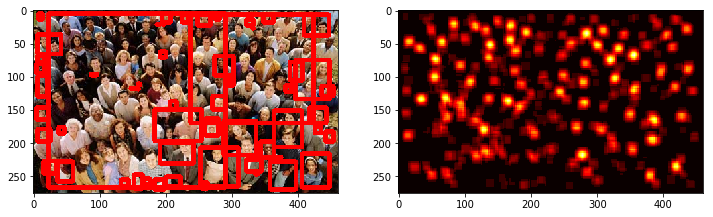

In [171]:
heatmap, labels = draw_small_heatmap(test_heat, all_boxes, 1)
final_box = draw_labeled_bboxes(np.copy(test_heat), labels)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(final_box[:,:,::-1])

plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='hot')

plt.savefig('test_images/crowd/test2_count.jpg', format='jpg', dpi=100)

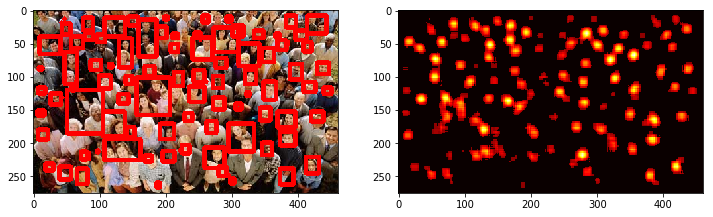

In [172]:
heatmap, labels = draw_small_heatmap(test_heat, all_boxes, 5)
final_box = draw_labeled_bboxes(np.copy(test_heat), labels)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(final_box[:,:,::-1])

plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='hot')

plt.savefig('test_images/crowd/test2_count_1.jpg', format='jpg', dpi=100)

In [154]:
labels[1]

104